<a href="https://colab.research.google.com/github/andrew-na-git/Stable-Diffusion/blob/main/Efficient_Diffusion_Models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Diffusion models Testing

In this document we test and build diffusion models and its variations

# Solving the KFP equation

We present classical methods to solve the KFP forward equation

In [38]:
## We start with standard diffusion model denoising diffusion probability model
## we first start by loading the required packages
import torch
import functools
from torch.optim import Adam, SGD
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torchvision.datasets import MNIST
import tqdm
import matplotlib.pyplot as plt

import scipy as sp
from scipy.sparse import coo_array
import numpy as np
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KernelDensity
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

In [39]:
# download mnist dataset
mnist = MNIST('.', train=True, transform=transforms.ToTensor(), download=True)

mnist_data = np.moveaxis(mnist.data.numpy(), 0, -1)
mnist_data.shape

(28, 28, 60000)

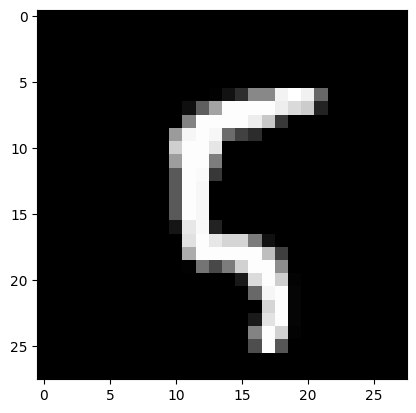

In [40]:
# look at one of the images

plt.imshow(mnist_data[:, :, 100], cmap="gray")

In [41]:
## we construct coefficient matrix and constant matrix
def construct_A(dx,dy,dt,f,g,s,H,W):
  A = np.zeros_like(g)
  for i in range(H):
    for j in range(W):
      if i == 0 and j == 0:
        a = 1/dt + f[i][j]/dx + f[i][j]/dy - 0.5*((g[i][j]**2)*s[i][j])/dx - 0.5*((g[i][j]**2)*s[i][j])/dy
        A[i][j] = a
      elif i == j and i > 0 and j > 0:
        a = 1/dt + f[i][j]/dx + f[i][j]/dy - 0.5*((g[i][j]**2)*s[i][j])/dx - 0.5*((g[i][j]**2)*s[i][j])/dy
        b = -f[i][j-1]/dy + 0.5*((g[i][j-1]**2)*s[i][j-1])/dy
        c = -f[i-1][j]/dx + 0.5*((g[i-1][j]**2)*s[i-1][j])/dx
        A[i][j] = a
        A[i][j-1] = b
        A[i-1][j] = c

  return A

def construct_B(dx,dy,dt,f,g,m_prev,del_sx,del_sy,H,W):
  B = m_prev/dt
  for i in range(H):
    for j in range(W):
      if i > 0 and j > 0 and i == j:
        B[i][j] -= f[i][j]/dx - f[i-1][j]/dx + f[i][j]/dy - f[i][j-1]/dy - 0.5*g[i][j]**2*del_sx[i][j] - 0.5*g[i][j]**2*del_sy[i][j]

  return B

def solve_pde(A,b):
  return sp.linalg.solve(A, b)

In [42]:
## construct the grid and Initial values
# N = mnist_data.data.shape[2] // 32
N = 100
H = mnist_data.data.shape[0]
W = mnist_data.data.shape[1]

x = mnist_data.astype(np.float64)[:, :, :N]

# x = np.zeros((H,W,N))
# for n in range(N):
#   x[:,:,n] = np.random.randint(0,255,(H,W))

t = np.linspace(0,1,N)

dx = 255/H
dy = 255/W
dt = 1/N

f = np.zeros((H,W,N))
g = np.zeros_like(f)
m = np.zeros_like(f)
s = np.zeros_like(g)
del_sx = np.zeros_like(g)
del_sy = np.zeros_like(g)

scaler = MinMaxScaler()

for n in range(N):
  f[:, :, n] = 250
  g[:,:,n] = 0.5**n
  x[:,:,n] = scaler.fit_transform(x[:,:,n])

## we fit the image onto a gaussian kernel
kde = KernelDensity(bandwidth=1.0, kernel='gaussian')
kde.fit(x[:,:,0].ravel()[:, None])

## obtain initial log probability
m[:,:,0] = kde.score_samples(x[:,:,0].ravel()[:, None]).reshape((H,W))
del_m = np.diff(m[:,:,0].ravel())
del_m = np.insert(del_m,0,0)

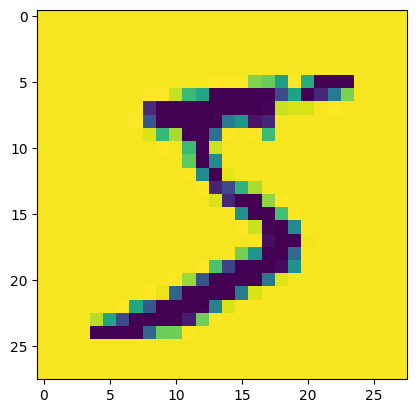

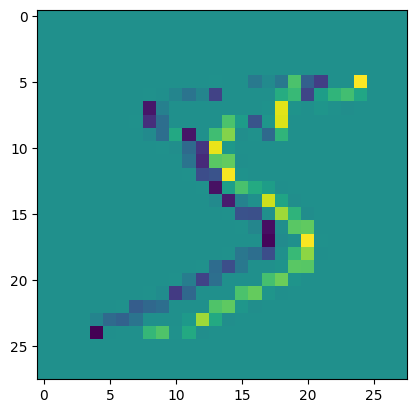

In [43]:
plt.imshow(m[:,:,0]) # this shows the initial log probability
plt.show()

plt.imshow(del_m.reshape(28, 28)) # so we can see that the score should look something like this after training
plt.show()

In [45]:
## we create the convolutional network

## let's just look at the first step output

model = torch.nn.Sequential(
    torch.nn.Conv1d(1, 1, kernel_size=1, stride=1, padding=1),
    torch.nn.ReLU(),
    torch.nn.Conv1d(1, 1, kernel_size=1, stride=1, padding=1),
    torch.nn.ReLU(),
    torch.nn.MaxPool1d(kernel_size=1),
    torch.nn.Flatten(),
    torch.nn.Linear(H*W + 4, 60),
    torch.nn.ReLU(),
    torch.nn.Linear(60, 30),
    torch.nn.ReLU(),
    torch.nn.Linear(30, H*W),
    torch.nn.Sigmoid()
)

model = model.double()
loss_fn = torch.nn.MSELoss()
optimizer = SGD(model.parameters(), lr=0.3)

## for n = 0

# train_x_data, _, train_y_data, _ = train_test_split(x[:,:,0].ravel(), del_m, train_size=1.0, shuffle=True)

# train_x_data = np.random.choice(x[:,:,0].ravel(),len(x[:,:,0].ravel()))
# train_y_data = np.random.choice(del_m,len(del_m))

train_x_data = scaler.fit_transform(m[:,:,0]).reshape(1,1,H*W) ## the issue was here, we were using inconsistent inputs!
train_y_data = del_m

# loader = DataLoader(list(zip(train_x_data, train_y_data)), shuffle=True)
# model.cuda()
model.train()
err = 1
k = 0
while err > 1e-2:
  # for X_batch, y_batch in loader:
  y_pred = model(torch.tensor(train_x_data.reshape(1,1,H*W)))
  loss = loss_fn(y_pred.ravel(), torch.tensor(train_y_data))
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()
  err = loss.item()
  # k+=1

model.eval()
# model.cpu()
s[:,:,0] = model(torch.tensor(scaler.fit_transform(m[:,:,0]).reshape(1,1,H*W))).reshape((H,W)).detach().numpy() # s is our score function approximated by the CNN
del_sx[1:,:,0] = np.diff(s[:,:,0],axis=0)
del_sx[0,:,0] = 0
del_sy[:,1:,0] = np.diff(s[:,:,0],axis=1)
del_sy[:,0,0] = 0

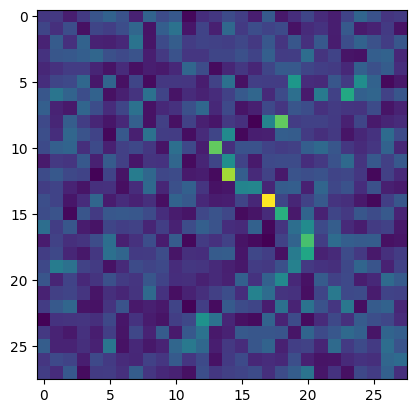

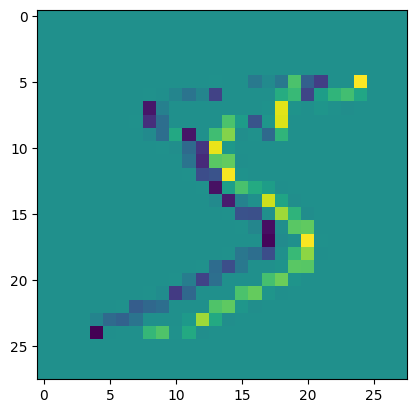

In [46]:
plt.imshow(s[:,:,0]) # we are now learning the right output!
plt.show()

plt.imshow(del_m.reshape(28, 28)) # so we can see that the score should look something like this after training
plt.show()

  0%|          | 0/99 [00:00<?, ?it/s]

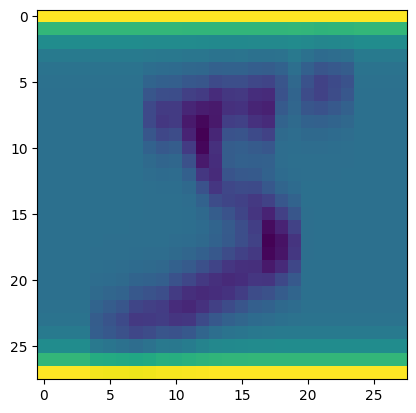

  1%|          | 1/99 [00:00<00:18,  5.34it/s]

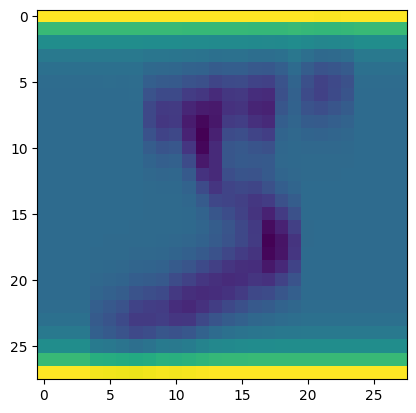

  2%|▏         | 2/99 [00:00<00:17,  5.60it/s]

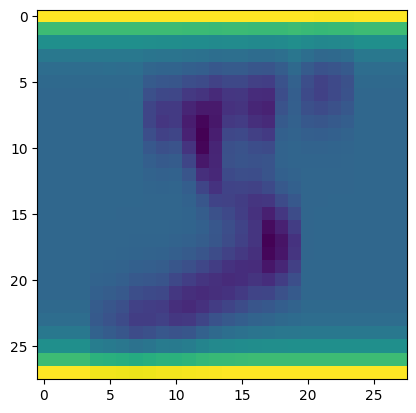

  3%|▎         | 3/99 [00:00<00:16,  5.74it/s]

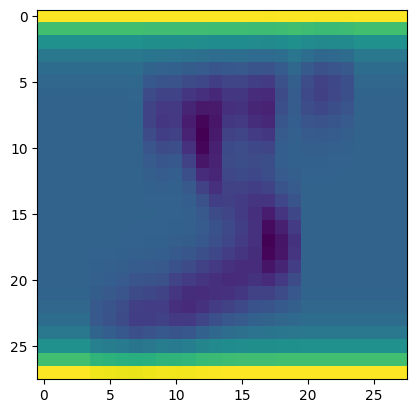

  4%|▍         | 4/99 [00:00<00:17,  5.43it/s]

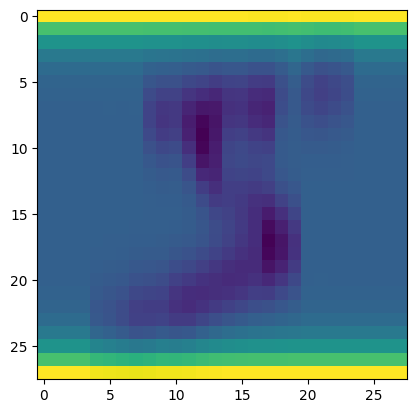

  5%|▌         | 5/99 [00:00<00:16,  5.62it/s]

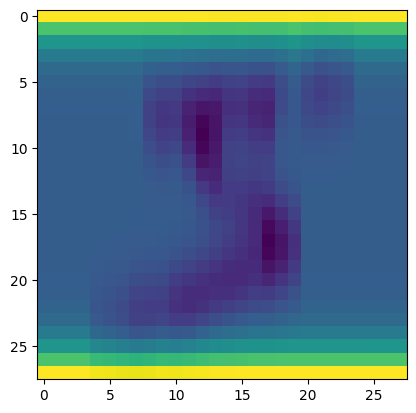

  6%|▌         | 6/99 [00:01<00:16,  5.73it/s]

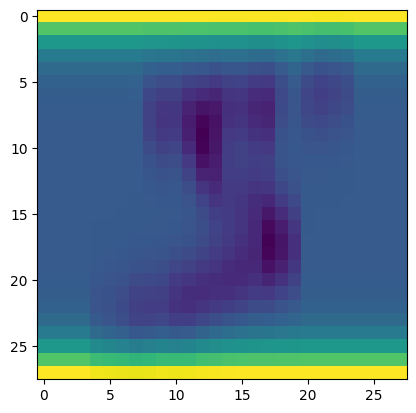

  7%|▋         | 7/99 [00:01<00:16,  5.64it/s]

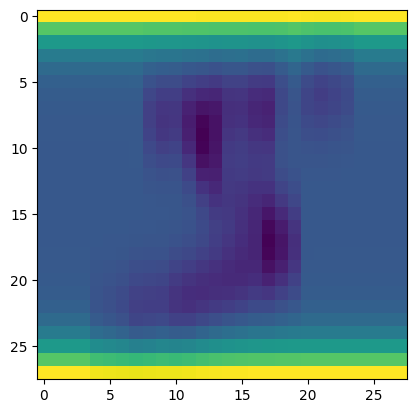

  8%|▊         | 8/99 [00:01<00:15,  5.69it/s]

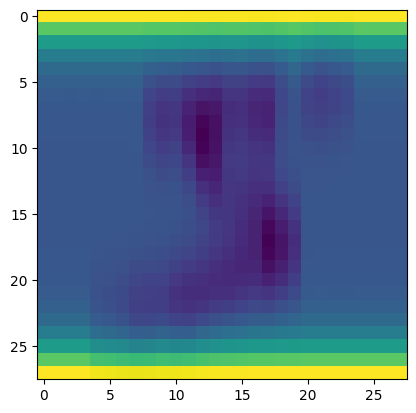

  9%|▉         | 9/99 [00:01<00:15,  5.85it/s]

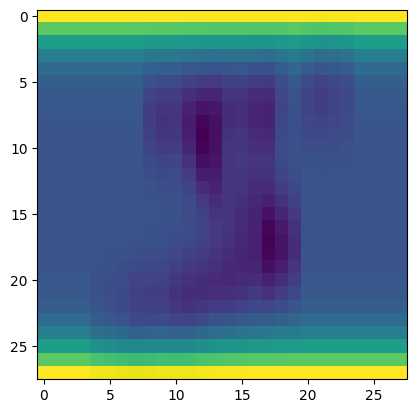

 10%|█         | 10/99 [00:01<00:15,  5.74it/s]

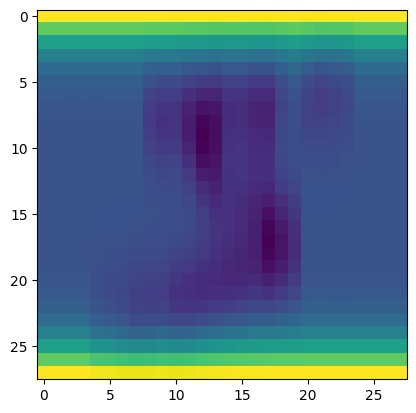

 11%|█         | 11/99 [00:01<00:15,  5.82it/s]

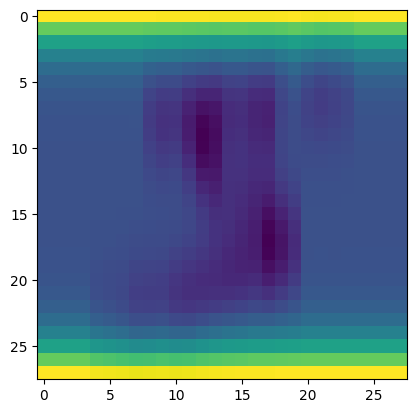

 12%|█▏        | 12/99 [00:02<00:15,  5.63it/s]

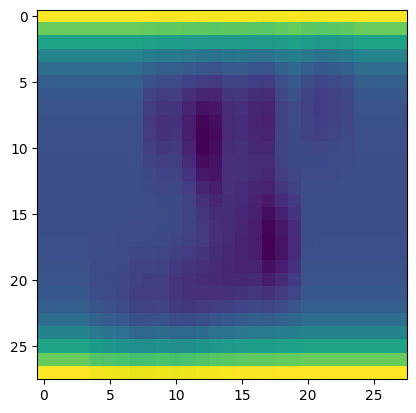

 13%|█▎        | 13/99 [00:02<00:15,  5.42it/s]

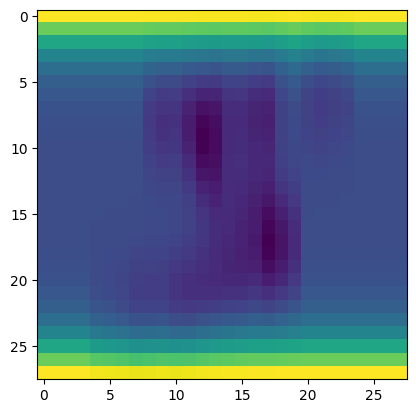

 14%|█▍        | 14/99 [00:02<00:16,  5.27it/s]

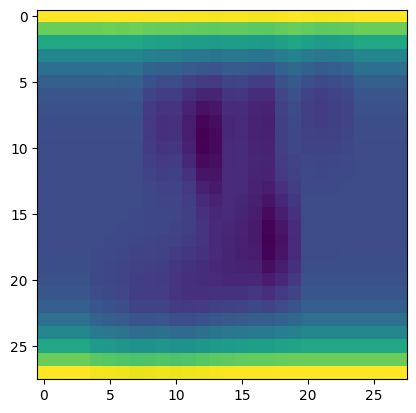

 15%|█▌        | 15/99 [00:02<00:16,  5.25it/s]

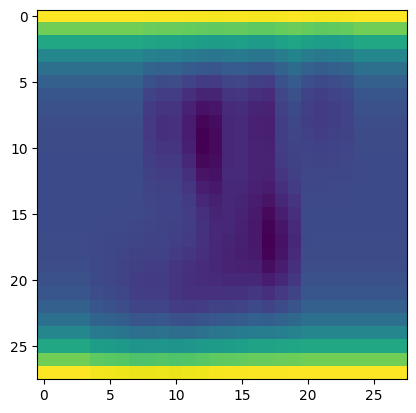

 16%|█▌        | 16/99 [00:02<00:15,  5.50it/s]

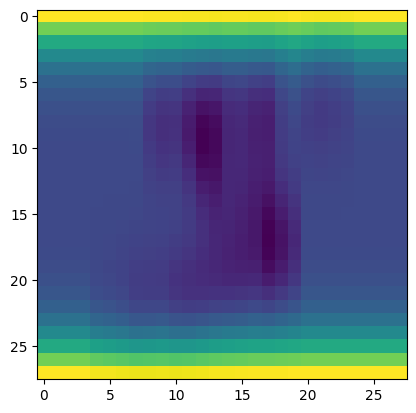

 17%|█▋        | 17/99 [00:03<00:15,  5.41it/s]

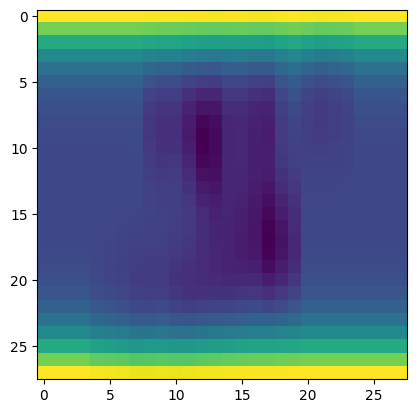

 18%|█▊        | 18/99 [00:03<00:15,  5.34it/s]

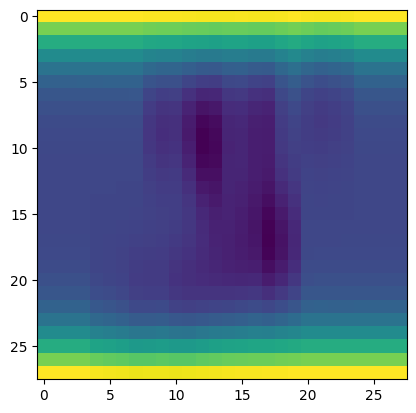

 19%|█▉        | 19/99 [00:03<00:14,  5.33it/s]

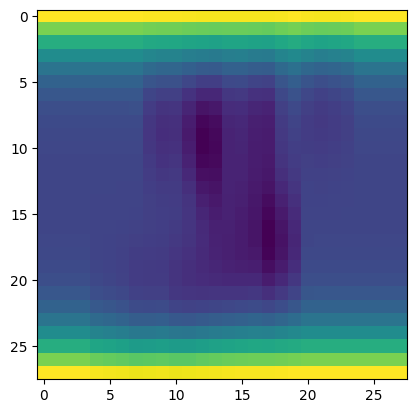

 20%|██        | 20/99 [00:03<00:14,  5.38it/s]

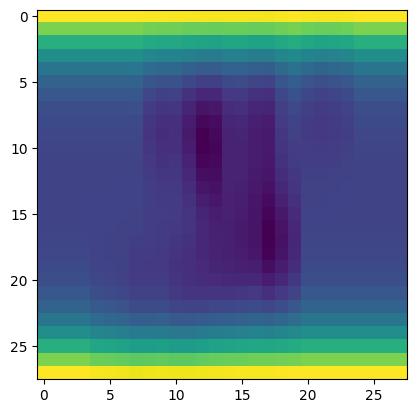

 21%|██        | 21/99 [00:03<00:14,  5.37it/s]

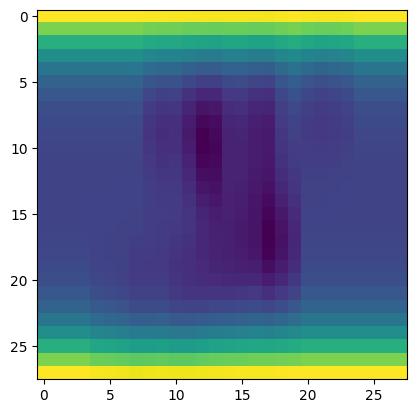

 22%|██▏       | 22/99 [00:03<00:14,  5.45it/s]

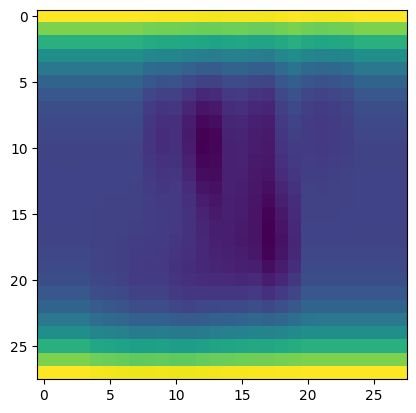

 23%|██▎       | 23/99 [00:04<00:14,  5.35it/s]

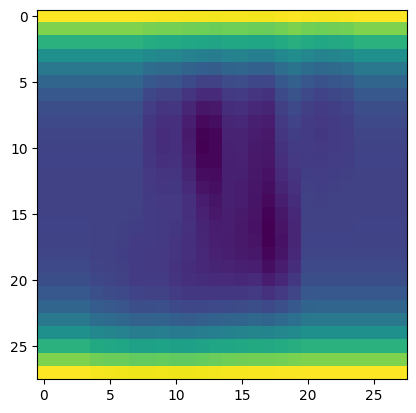

 24%|██▍       | 24/99 [00:04<00:14,  5.26it/s]

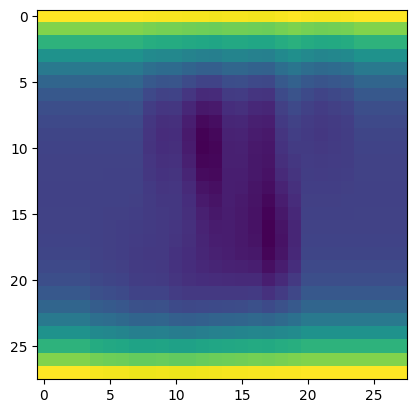

 25%|██▌       | 25/99 [00:04<00:13,  5.46it/s]

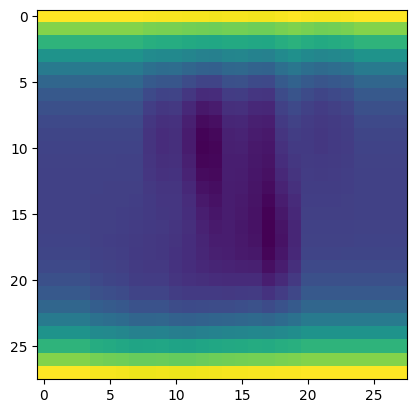

 26%|██▋       | 26/99 [00:04<00:13,  5.47it/s]

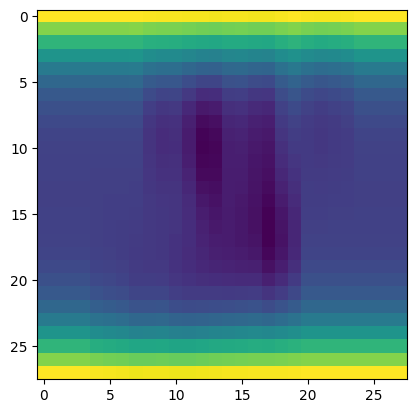

 27%|██▋       | 27/99 [00:04<00:12,  5.62it/s]

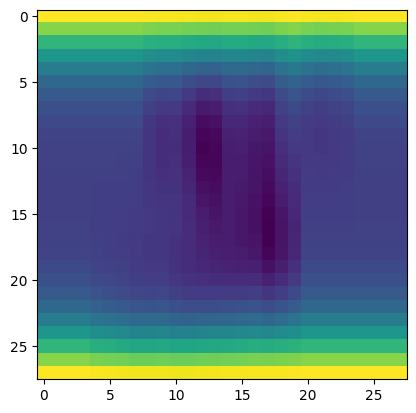

 28%|██▊       | 28/99 [00:05<00:13,  5.38it/s]

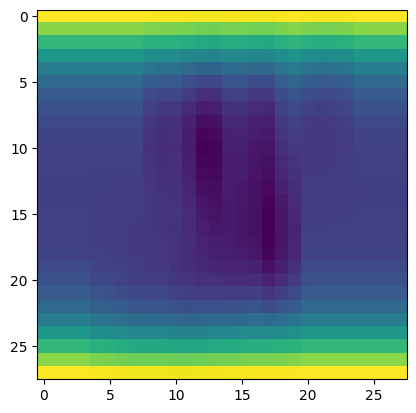

 29%|██▉       | 29/99 [00:05<00:13,  5.30it/s]

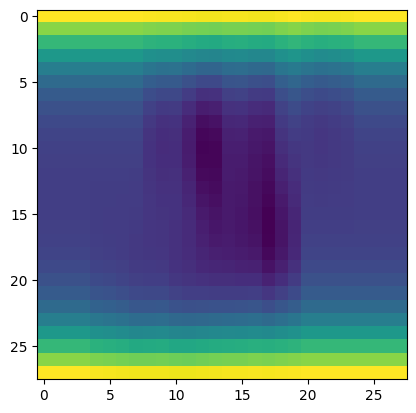

 30%|███       | 30/99 [00:05<00:13,  5.24it/s]

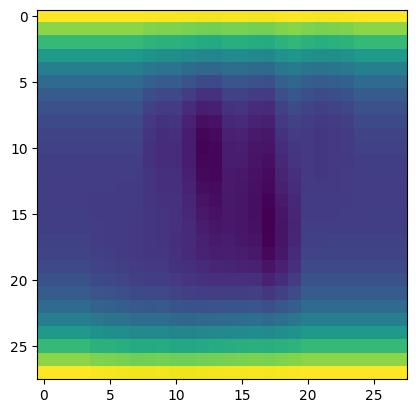

 31%|███▏      | 31/99 [00:05<00:13,  5.12it/s]

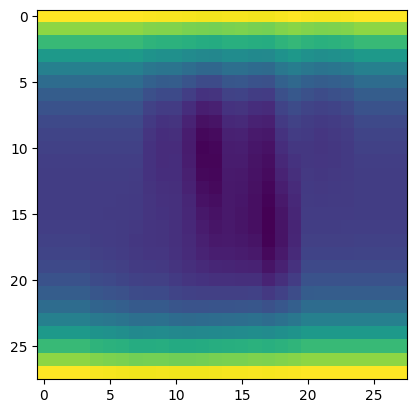

 32%|███▏      | 32/99 [00:05<00:12,  5.17it/s]

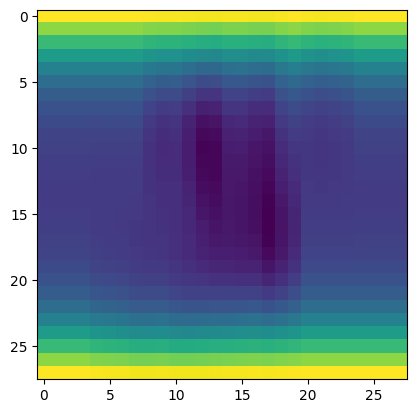

 33%|███▎      | 33/99 [00:06<00:12,  5.15it/s]

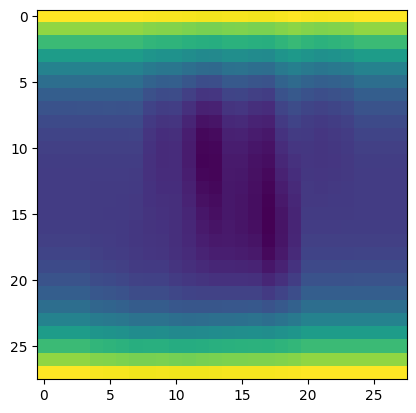

 34%|███▍      | 34/99 [00:06<00:12,  5.17it/s]

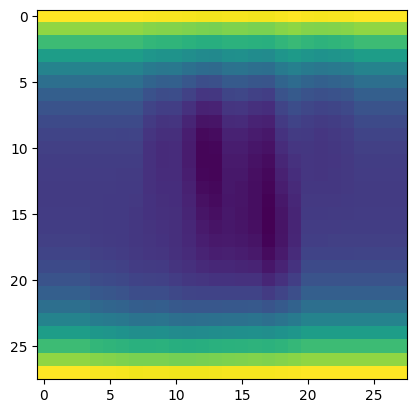

 35%|███▌      | 35/99 [00:06<00:15,  4.16it/s]

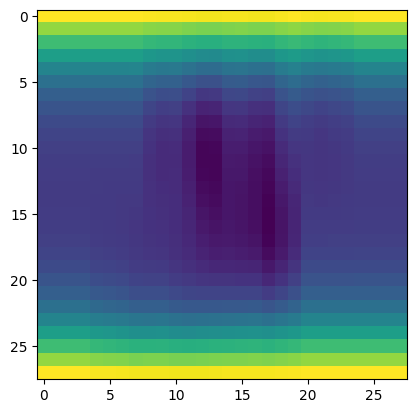

 36%|███▋      | 36/99 [00:06<00:13,  4.52it/s]

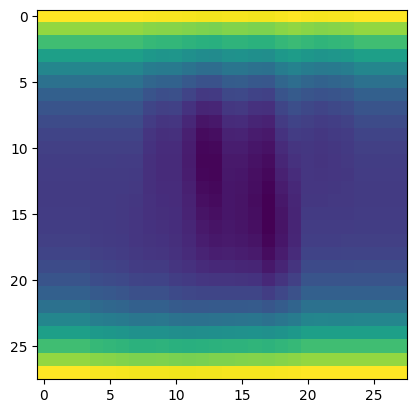

 37%|███▋      | 37/99 [00:06<00:12,  4.91it/s]

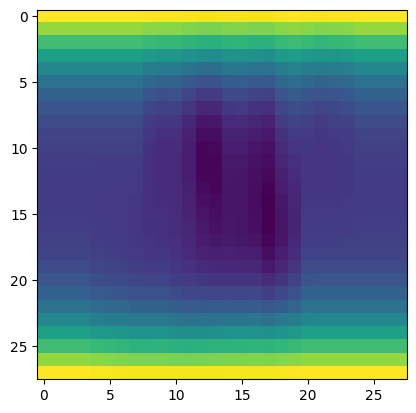

 38%|███▊      | 38/99 [00:07<00:11,  5.22it/s]

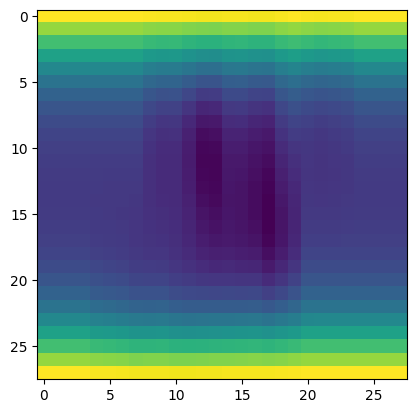

 39%|███▉      | 39/99 [00:07<00:11,  5.21it/s]

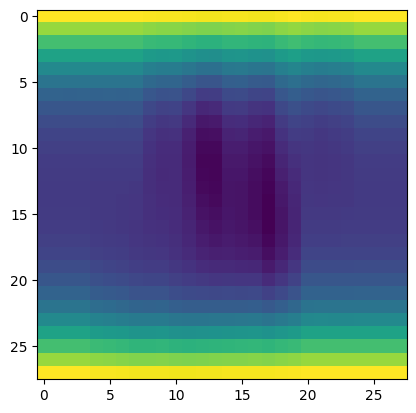

 40%|████      | 40/99 [00:07<00:11,  5.15it/s]

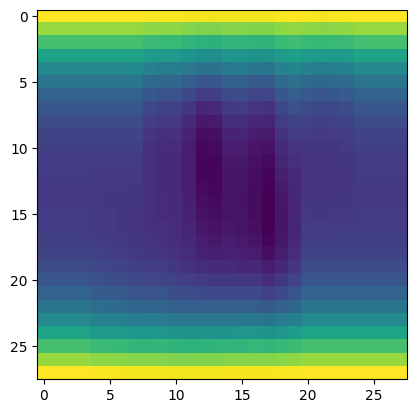

 41%|████▏     | 41/99 [00:07<00:11,  5.11it/s]

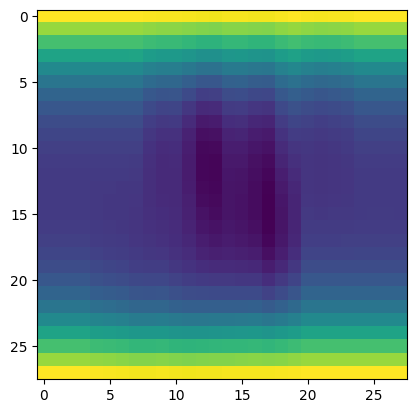

 42%|████▏     | 42/99 [00:07<00:10,  5.33it/s]

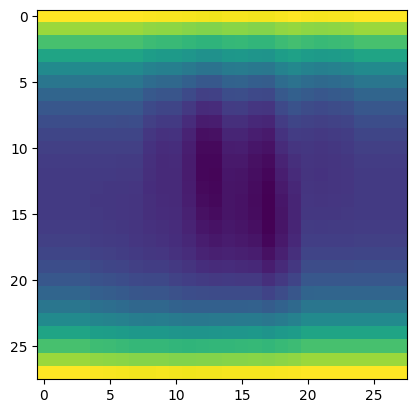

 43%|████▎     | 43/99 [00:08<00:10,  5.57it/s]

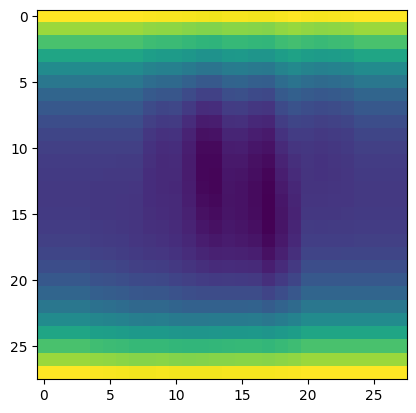

 44%|████▍     | 44/99 [00:08<00:10,  5.31it/s]

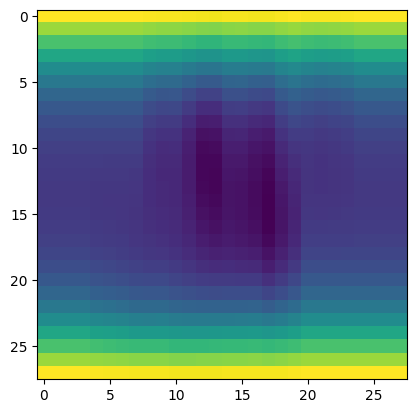

 45%|████▌     | 45/99 [00:08<00:10,  4.93it/s]

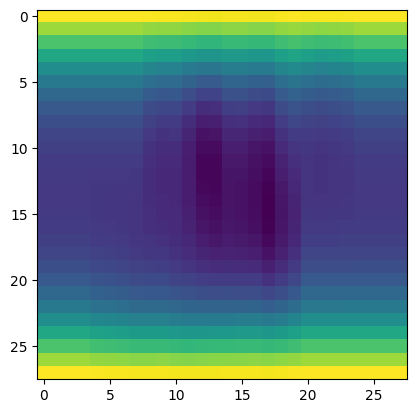

 46%|████▋     | 46/99 [00:08<00:11,  4.46it/s]

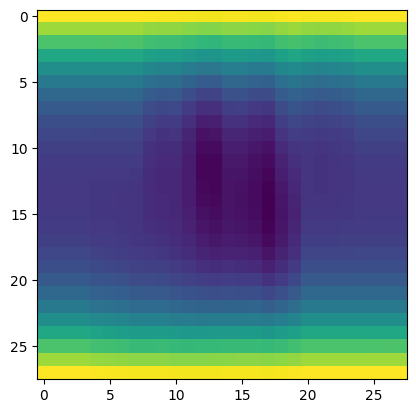

 47%|████▋     | 47/99 [00:09<00:12,  4.17it/s]

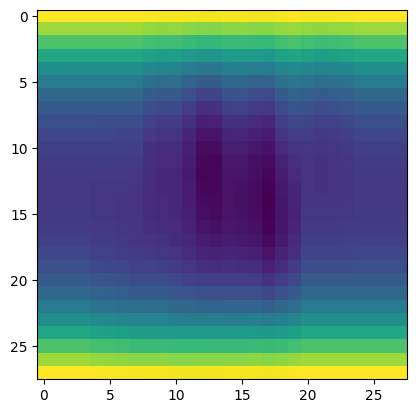

 48%|████▊     | 48/99 [00:09<00:12,  4.02it/s]

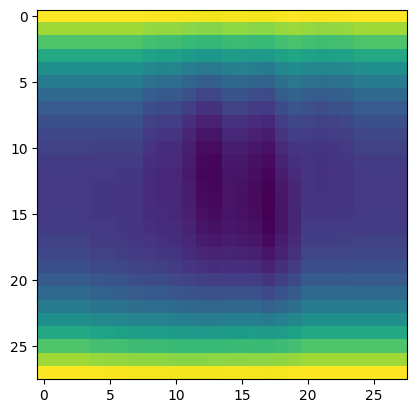

 49%|████▉     | 49/99 [00:09<00:12,  3.91it/s]

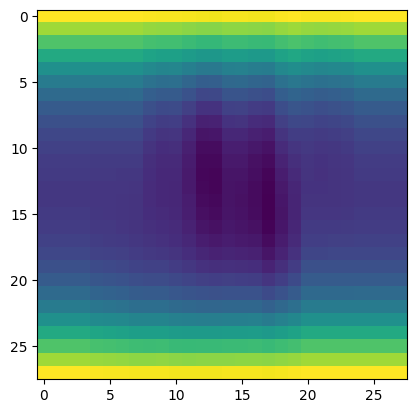

 51%|█████     | 50/99 [00:09<00:12,  3.86it/s]

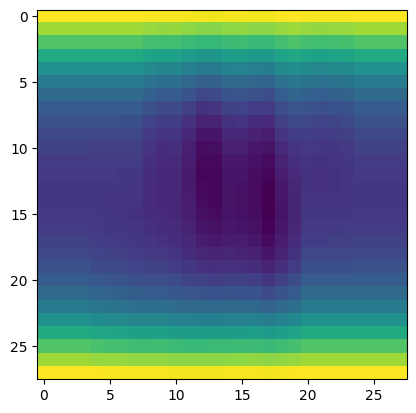

 52%|█████▏    | 51/99 [00:10<00:12,  3.77it/s]

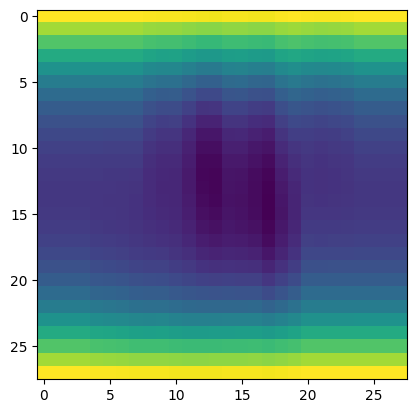

 53%|█████▎    | 52/99 [00:10<00:12,  3.92it/s]

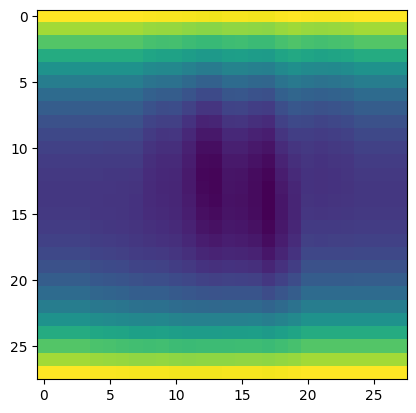

 54%|█████▎    | 53/99 [00:10<00:10,  4.32it/s]

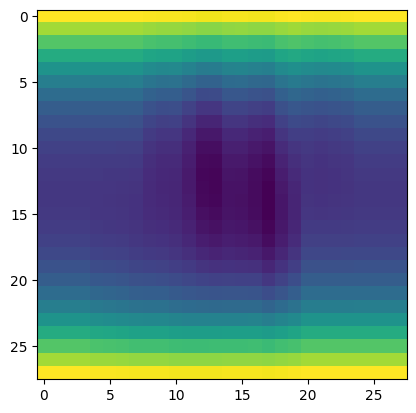

 55%|█████▍    | 54/99 [00:10<00:10,  4.48it/s]

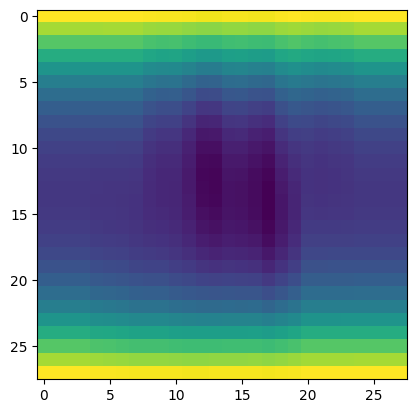

 56%|█████▌    | 55/99 [00:10<00:09,  4.70it/s]

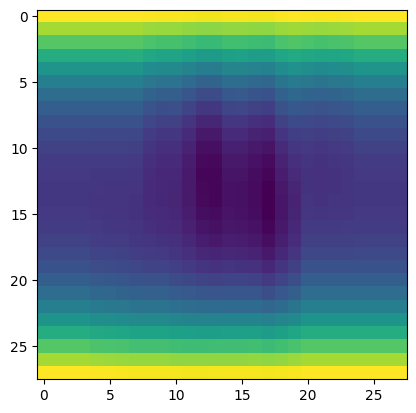

 57%|█████▋    | 56/99 [00:11<00:08,  4.86it/s]

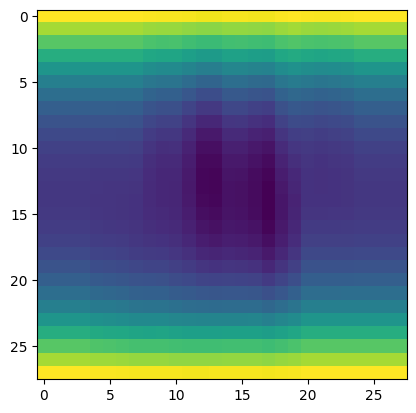

 58%|█████▊    | 57/99 [00:11<00:08,  4.89it/s]

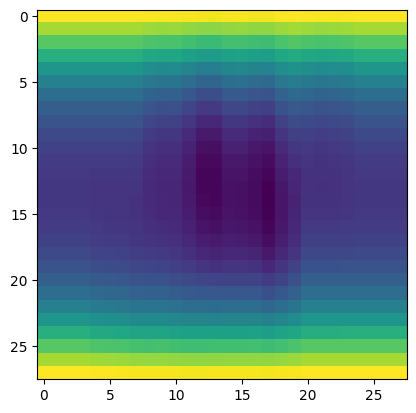

 59%|█████▊    | 58/99 [00:11<00:08,  4.98it/s]

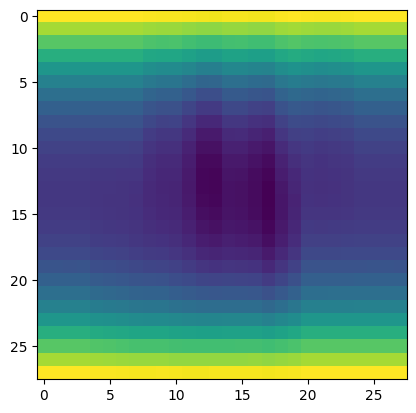

 60%|█████▉    | 59/99 [00:11<00:07,  5.26it/s]

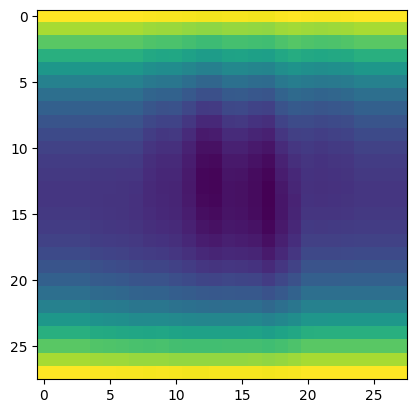

 61%|██████    | 60/99 [00:11<00:07,  5.16it/s]

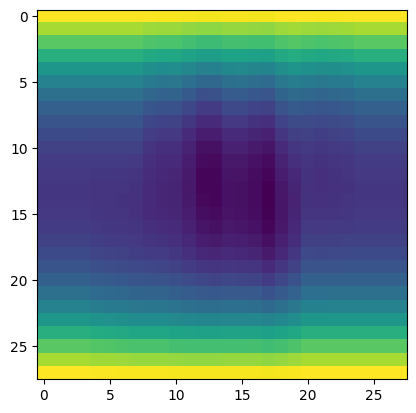

 62%|██████▏   | 61/99 [00:12<00:07,  5.35it/s]

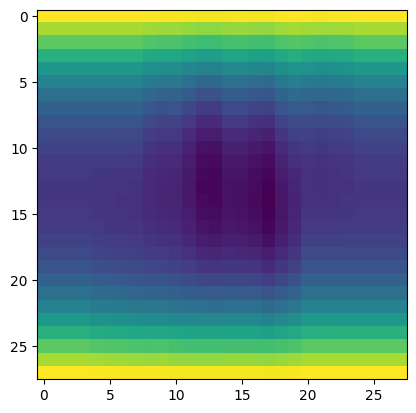

 63%|██████▎   | 62/99 [00:12<00:07,  5.18it/s]

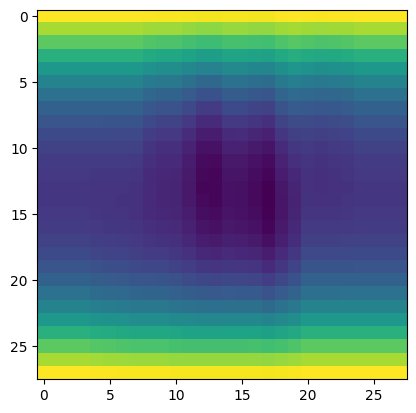

 64%|██████▎   | 63/99 [00:12<00:06,  5.26it/s]

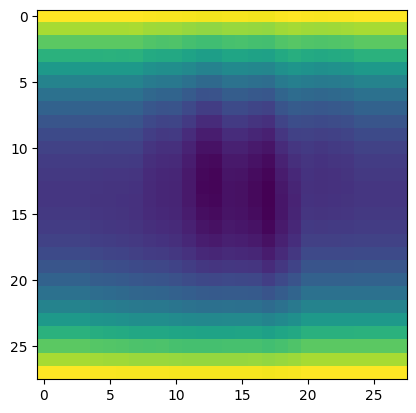

 65%|██████▍   | 64/99 [00:12<00:06,  5.54it/s]

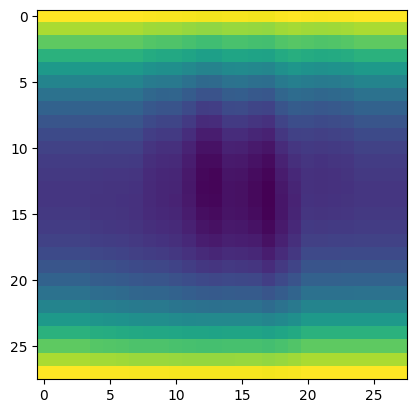

 66%|██████▌   | 65/99 [00:12<00:06,  5.65it/s]

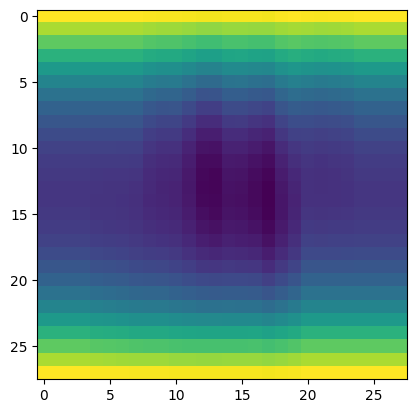

 67%|██████▋   | 66/99 [00:12<00:05,  5.53it/s]

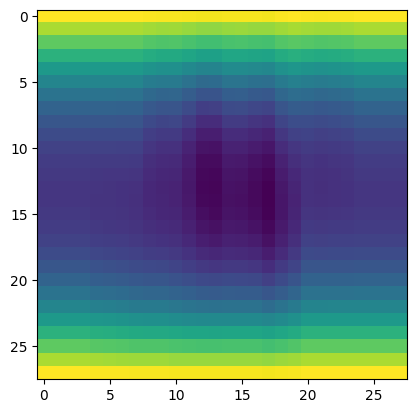

 68%|██████▊   | 67/99 [00:13<00:05,  5.68it/s]

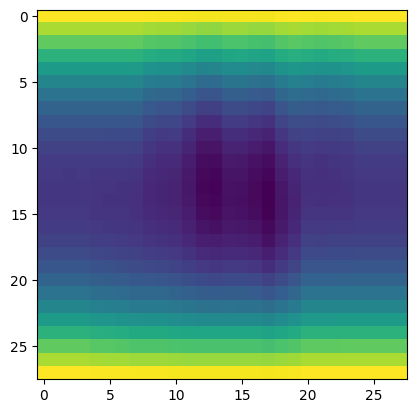

 69%|██████▊   | 68/99 [00:13<00:05,  5.66it/s]

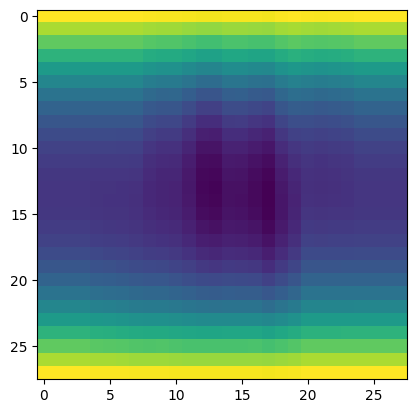

 70%|██████▉   | 69/99 [00:13<00:05,  5.85it/s]

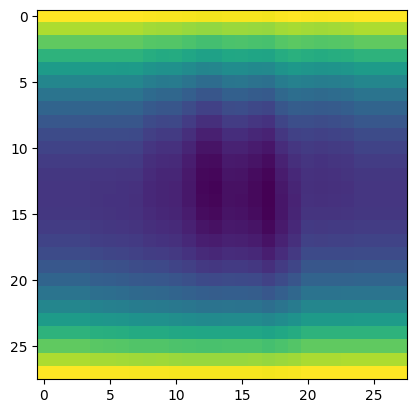

 71%|███████   | 70/99 [00:13<00:05,  5.67it/s]

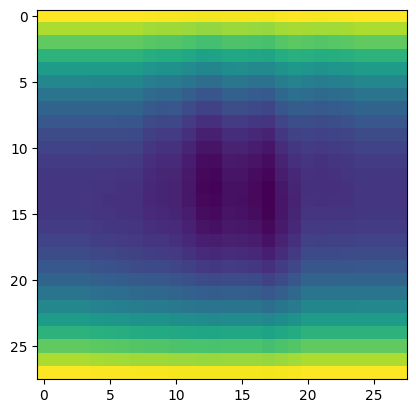

 72%|███████▏  | 71/99 [00:13<00:05,  5.59it/s]

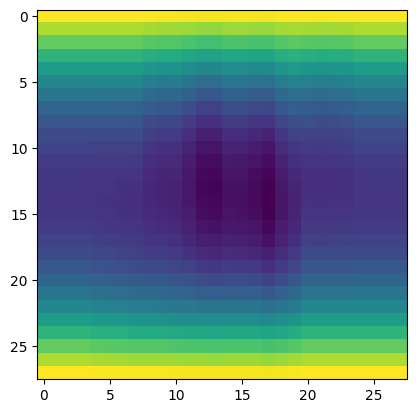

 73%|███████▎  | 72/99 [00:14<00:04,  5.63it/s]

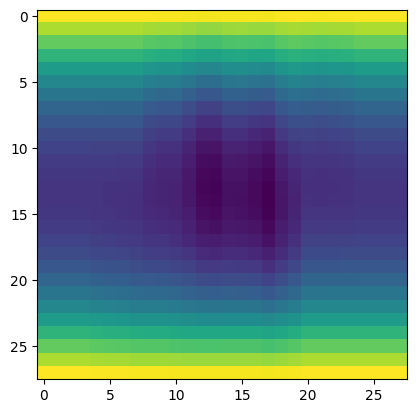

 74%|███████▎  | 73/99 [00:14<00:04,  5.79it/s]

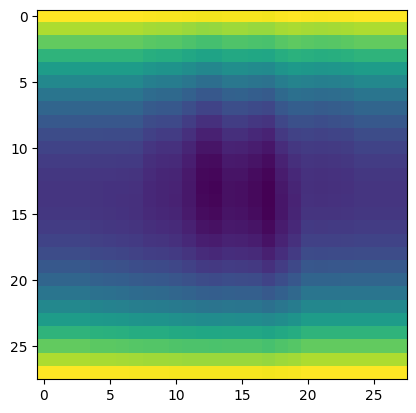

 75%|███████▍  | 74/99 [00:14<00:04,  5.53it/s]

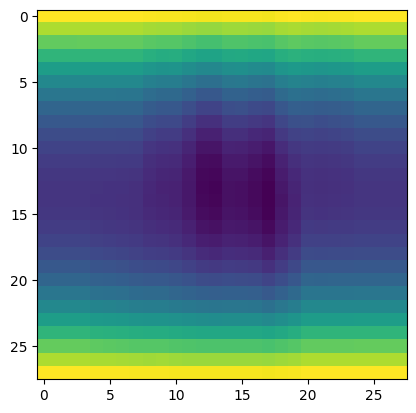

 76%|███████▌  | 75/99 [00:14<00:04,  5.39it/s]

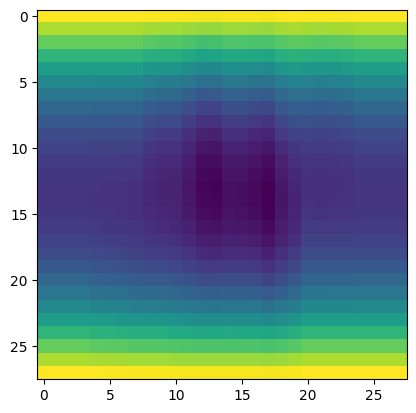

 77%|███████▋  | 76/99 [00:14<00:04,  5.39it/s]

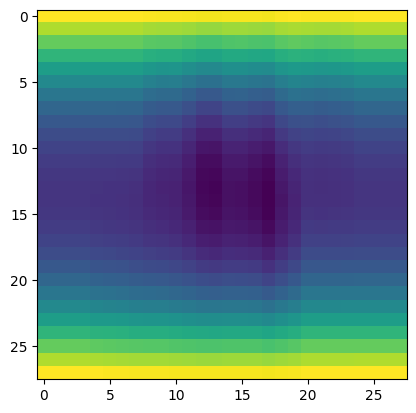

 78%|███████▊  | 77/99 [00:14<00:04,  5.33it/s]

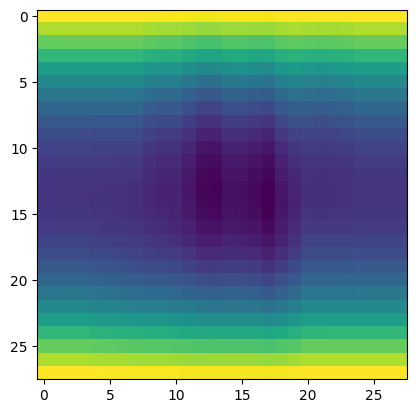

 79%|███████▉  | 78/99 [00:15<00:03,  5.47it/s]

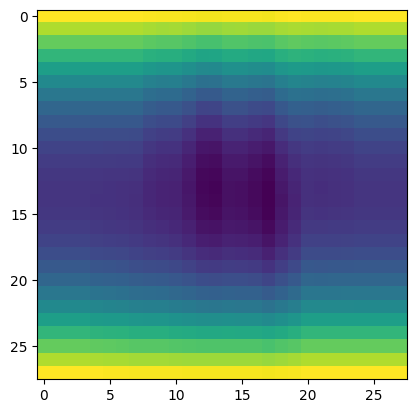

 80%|███████▉  | 79/99 [00:15<00:04,  4.12it/s]

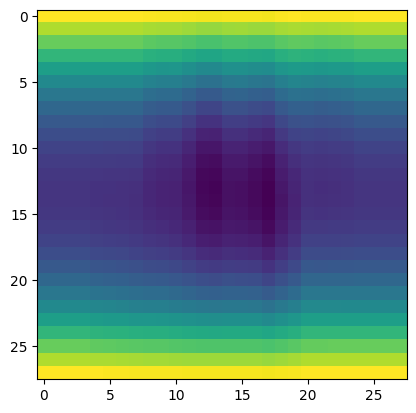

 81%|████████  | 80/99 [00:15<00:04,  4.36it/s]

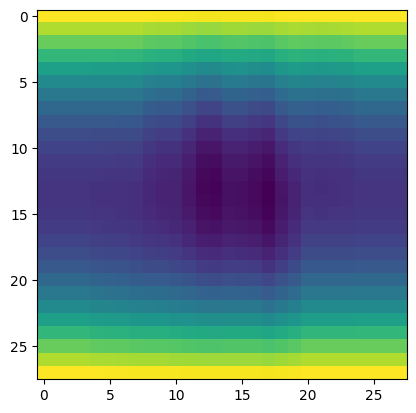

 82%|████████▏ | 81/99 [00:15<00:03,  4.51it/s]

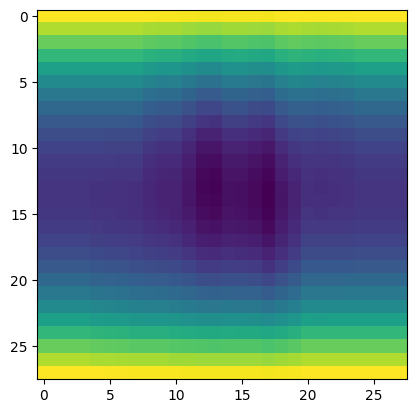

 83%|████████▎ | 82/99 [00:16<00:03,  4.63it/s]

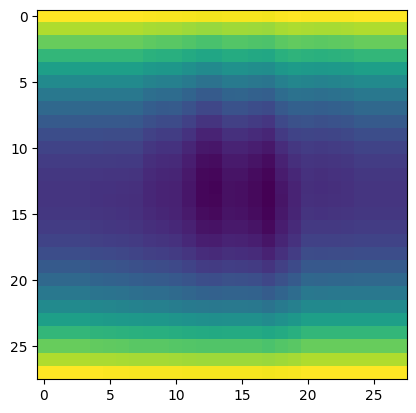

 84%|████████▍ | 83/99 [00:16<00:03,  4.72it/s]

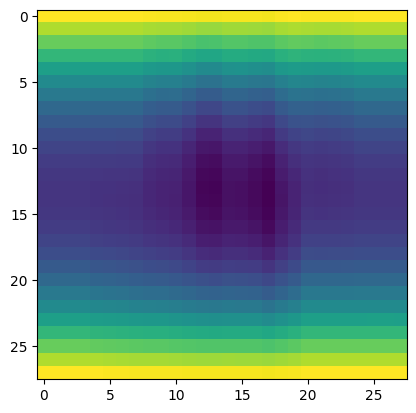

 85%|████████▍ | 84/99 [00:16<00:03,  4.80it/s]

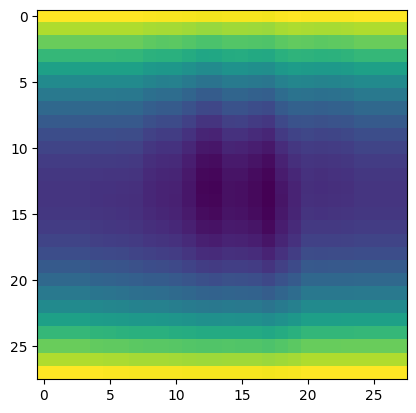

 86%|████████▌ | 85/99 [00:16<00:02,  4.97it/s]

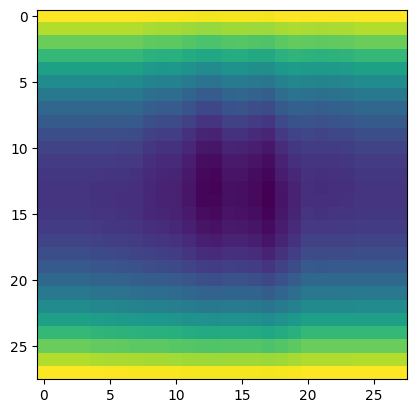

 87%|████████▋ | 86/99 [00:16<00:02,  5.08it/s]

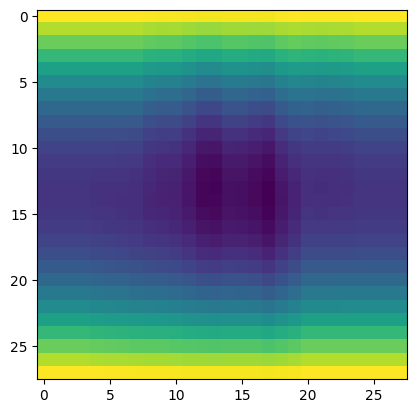

 88%|████████▊ | 87/99 [00:17<00:02,  5.02it/s]

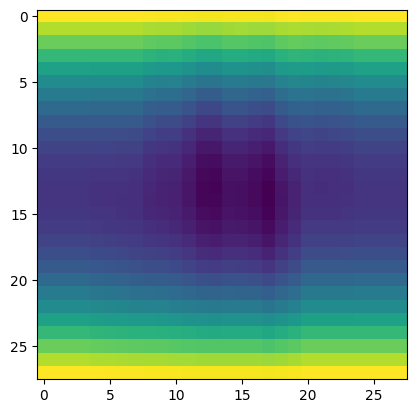

 89%|████████▉ | 88/99 [00:17<00:02,  4.97it/s]

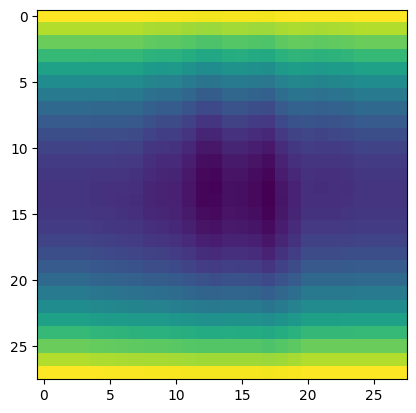

 90%|████████▉ | 89/99 [00:17<00:01,  5.11it/s]

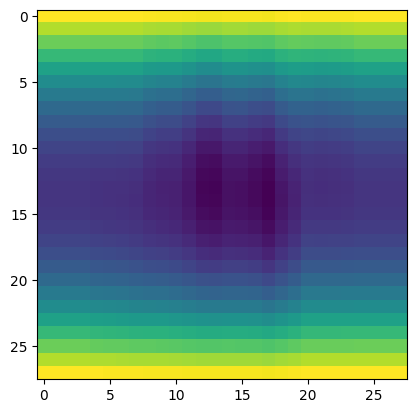

 91%|█████████ | 90/99 [00:17<00:01,  5.02it/s]

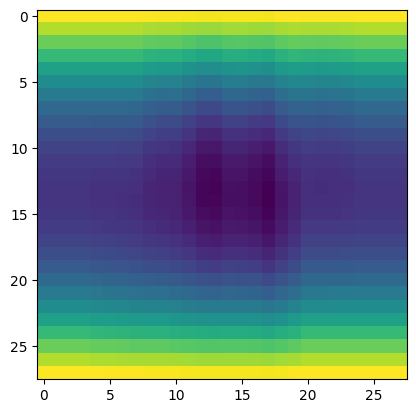

 92%|█████████▏| 91/99 [00:17<00:01,  5.16it/s]

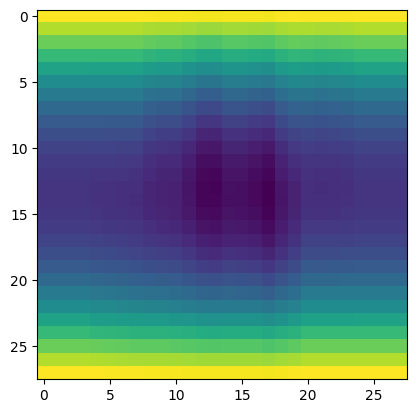

 93%|█████████▎| 92/99 [00:18<00:01,  5.26it/s]

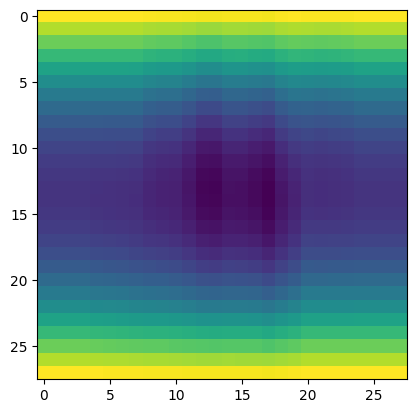

 94%|█████████▍| 93/99 [00:18<00:01,  5.25it/s]

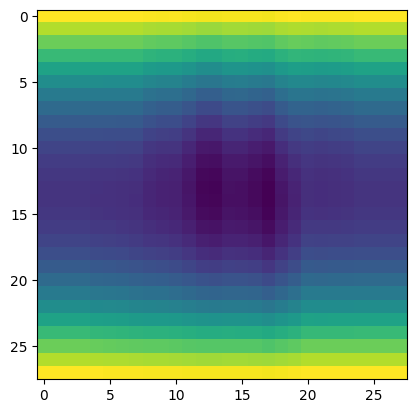

 95%|█████████▍| 94/99 [00:18<00:00,  5.34it/s]

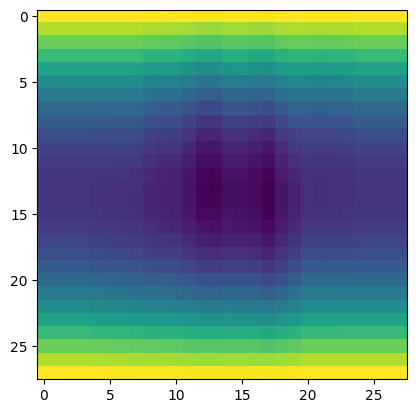

 96%|█████████▌| 95/99 [00:18<00:00,  5.52it/s]

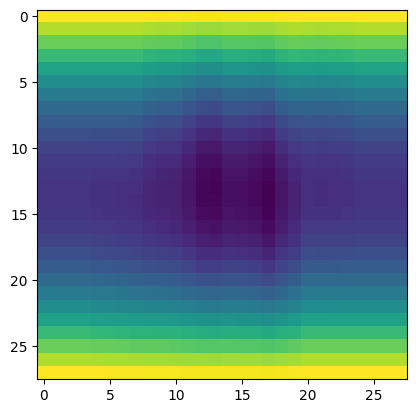

 97%|█████████▋| 96/99 [00:18<00:00,  5.45it/s]

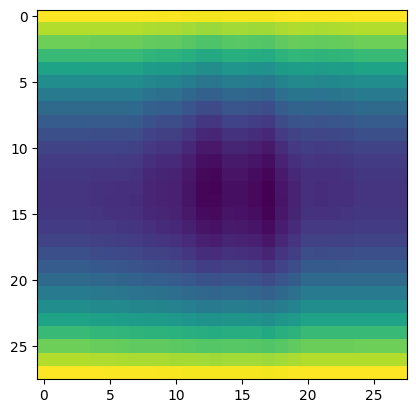

 98%|█████████▊| 97/99 [00:18<00:00,  5.47it/s]

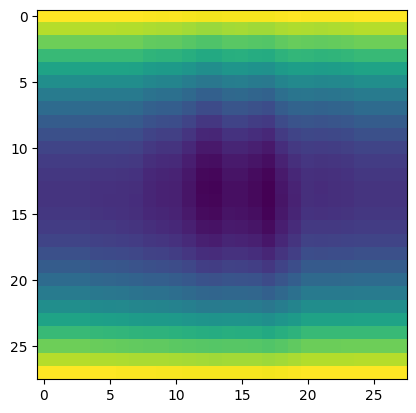

 99%|█████████▉| 98/99 [00:19<00:00,  5.56it/s]

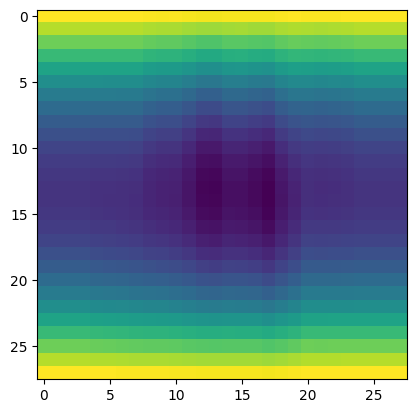

100%|██████████| 99/99 [00:19<00:00,  5.13it/s]


In [57]:
## for n = 0

# train_x_data, _, train_y_data, _ = train_test_split(x[:,:,0].ravel(), del_m, train_size=1.0, shuffle=True)

# train_x_data = np.random.choice(x[:,:,0].ravel(),len(x[:,:,0].ravel()))
# train_y_data = np.random.choice(del_m,len(del_m))

## initialize score function from previous timestep
# model.eval()
s[:,:,n] = s[:,:,n-1] # model(torch.tensor(scaler.fit_transform(m[:,:,n]).reshape(1,1,H*W))).cpu().reshape((H,W)).detach().numpy()
del_sx[1:,:,n] = np.diff(s[:,:,n],axis=0)
del_sx[0,:,n] = 0
del_sy[:,1:,n] = np.diff(s[:,:,n],axis=1)
del_sy[:,0,n] = 0

tqdm_len = tqdm.trange(1,N)

# model.cuda()

for n in tqdm_len:
  err = 1
  k = 0
  while err > 1e-2:
    A = construct_A(dx,dy,dt,f[:,:,n],g[:,:,n],s[:,:,n],H,W)
    B = construct_B(dx,dy,dt,f[:,:,n],g[:,:,n],m[:,:,n],del_sx[:,:,n],del_sy[:,:,n],H,W)
    m[:,:,n] = solve_pde(A,B) # m is the transition log probability we solve using the KFP equation
    del_m = np.diff(m[:,:,n].ravel())
    del_m = np.insert(del_m,0,0)

    plt.imshow(m[:,:,n]) # we are now learning the right output!
    plt.show()

    # plt.imshow(s[:,:,n]) # we are now learning the right output!
    # plt.show()

    err = mean_squared_error(s[:,:,n].ravel(),del_m)

    # train_x_data, _, train_y_data, _ = train_test_split(x[:,:,0].ravel(), del_m, train_size=1.0, shuffle=True)

    # train_x_data = np.random.choice(scaler.fit_transform(x[:,:,n]).ravel(),len(x[:,:,0].ravel()))
    # train_y_data = np.random.choice(del_m,len(del_m))

    train_x_data = scaler.fit_transform(m[:,:,n]).ravel()
    train_y_data = del_m

    # loader = DataLoader(list(zip(train_x_data, train_y_data)), shuffle=True)
    model.train()
    # n_epochs = 100 # let's look for accuracy before looking at epochs
    # for epoch in range(n_epochs):
      # for X_batch, y_batch in loader:
    y_pred = model(torch.tensor(train_x_data.reshape(1,1,H*W), requires_grad=True))
    loss = loss_fn(y_pred.ravel(), torch.tensor(train_y_data))
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    model.eval()
    s[:,:,n] = model(torch.tensor(scaler.fit_transform(m[:,:,n]).reshape(1,1,H*W))).cpu().reshape((H,W)).detach().numpy()
    del_sx[1:,:,n] = np.diff(s[:,:,n],axis=0)
    del_sx[0,:,n] = 0
    del_sy[:,1:,n] = np.diff(s[:,:,n],axis=1)
    del_sy[:,0,n] = 0

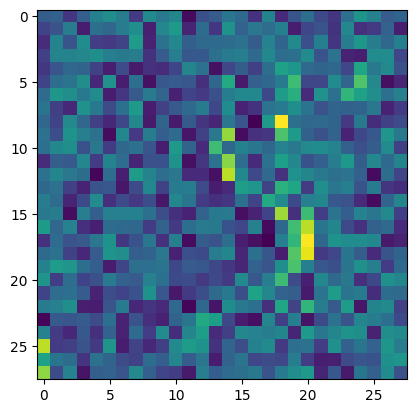

In [58]:
plt.imshow(s[:,:,-1]) # we can see that this is incorrect.
plt.show()

In [ ]:
def marginal_prob_std(t, sigma):
  """Compute the mean and standard deviation of $p_{0t}(x(t) | x(0))$.

  Args:
    t: A vector of time steps.
    sigma: The $\sigma$ in our SDE.

  Returns:
    The standard deviation.
  """
  t = torch.tensor(t)
  return torch.sqrt((sigma**(2 * t) - 1.) / 2. / np.log(sigma))

def diffusion_coeff(t, sigma):
  """Compute the diffusion coefficient of our SDE.

  Args:
    t: A vector of time steps.
    sigma: The $\sigma$ in our SDE.

  Returns:
    The vector of diffusion coefficients.
  """
  return torch.tensor(sigma**t)


sigma =  0.5 #@param {'type':'number'}
marginal_prob_std_fn = functools.partial(marginal_prob_std, sigma=sigma)
diffusion_coeff_fn = functools.partial(diffusion_coeff, sigma=sigma)

In [ ]:
from scipy import integrate

## The error tolerance for the black-box ODE solver
error_tolerance = 1e-6 #@param {'type': 'number'}
def ode_sampler(score_model,
                marginal_prob_std,
                diffusion_coeff,
                batch_size=64,
                atol=error_tolerance,
                rtol=error_tolerance,
                device='cpu',
                z=None,
                eps=1e-3):
  """Generate samples from score-based models with black-box ODE solvers.

  Args:
    score_model: A PyTorch model that represents the time-dependent score-based model.
    marginal_prob_std: A function that returns the standard deviation
      of the perturbation kernel.
    diffusion_coeff: A function that returns the diffusion coefficient of the SDE.
    batch_size: The number of samplers to generate by calling this function once.
    atol: Tolerance of absolute errors.
    rtol: Tolerance of relative errors.
    device: 'cuda' for running on GPUs, and 'cpu' for running on CPUs.
    z: The latent code that governs the final sample. If None, we start from p_1;
      otherwise, we start from the given z.
    eps: The smallest time step for numerical stability.
  """
  t = torch.ones(batch_size, device=device)
  # Create the latent code
  if z is None:
    init_x = torch.randn(batch_size, 1, 28, 28, device=device) \
      * marginal_prob_std(t)[:, None, None, None]
  else:
    init_x = z

  shape = init_x.shape

  def score_eval_wrapper(sample, time_steps):
    """A wrapper of the score-based model for use by the ODE solver."""
    sample = torch.tensor(sample, device=device, dtype=torch.double).reshape(1, 1, 28 * 28)
    time_steps = torch.tensor(time_steps, device=device, dtype=torch.float32).reshape((sample.shape[0], ))
    with torch.no_grad():
      score = score_model(sample)
    return score.cpu().numpy().reshape((-1,)).astype(np.float64)

  def ode_func(t, x):
    """The ODE function for use by the ODE solver."""
    time_steps = np.ones((shape[0],)) * t
    g = diffusion_coeff(torch.tensor(t)).cpu().numpy()
    return  -0.5 * (g**2) * score_eval_wrapper(x, time_steps)

  # Run the black-box ODE solver.
  res = integrate.solve_ivp(ode_func, (1., eps), init_x.reshape(-1).cpu().numpy(), rtol=rtol, atol=atol, method='RK45')
  print(f"Number of function evaluations: {res.nfev}")
  x = torch.tensor(res.y[:, -1], device=device).reshape(shape)

  return x

<ipython-input-28-542b96f3b2ce>:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t = torch.tensor(t)
<ipython-input-28-542b96f3b2ce>:25: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(sigma**t)


Number of function evaluations: 20


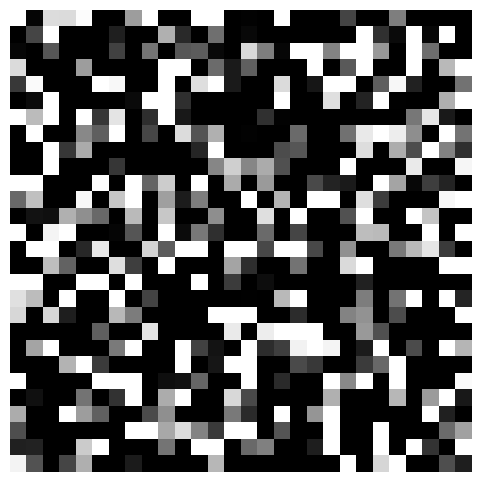

In [ ]:
from torchvision.utils import make_grid

device = 'cuda' #@param ['cuda', 'cpu'] {'type':'string'}

sample_batch_size = 1 #@param {'type':'integer'}
sampler = ode_sampler #@param ['Euler_Maruyama_sampler', 'pc_sampler', 'ode_sampler'] {'type': 'raw'}

## Generate samples using the specified sampler.
## the marginal_prob_std_fn needs to be changed to match m and diffusion_coeff_fn needs to
## be consistent with KFP equation
samples = sampler(model,
                  marginal_prob_std_fn,
                  diffusion_coeff_fn,
                  sample_batch_size,
                  device=device)

## Sample visualization.
%matplotlib inline
# import matplotlib.pyplot as plt
sample_grid = make_grid(samples, nrow=int(np.sqrt(sample_batch_size)))

plt.figure(figsize=(6,6))
plt.axis('off')
plt.imshow(sample_grid.permute(1, 2, 0).cpu(), vmin=0., vmax=1.)
plt.show()

# Using the KFP solver to generate images

tutorial on diffusion model can be found on https://colab.research.google.com/drive/1d2-L9uPKQNqZcgpK7CZzhHrCmwQsz5BC?usp=sharing


